# Flyouts
During a play, it is decided whether it will be a groundout, flyout, or hit. This notebook encompasses all baserunner advancement possibilities after a flyout has been decided.

So far, we can confirm that baserunner indulgence is positively correlated with advancing. The formulas are still unclear.

```python
dfc["threshold_1to2"] = -0.085 + 0.36*dfc["relevant_runner_indulgence_vibes"] - 0.38*dfc["relevant_runner_indulgence_vibes_sq"] \
                               + 0.24*dfc["relevant_runner_indulgence_vibes_4"] \
                               - 0.10*dfc["ballpark_elongation"] - 0.10*dfc["ballpark_inconvenience"]
dfc["threshold_2to3"] = 0.045 + 0.065*dfc["relevant_runner_indulgence_vibes"] + 0.30*dfc["relevant_relevant_runner_indulgence_vibes_sq"] \
                              - 0.10*dfc["ballpark_elongation"] - 0.10*dfc["ballpark_inconvenience"]
dfc["threshold_3to4"] = 0.45 + 0.35*dfc["relevant_runner_indulgence_vibes"] - 0.10*dfc["ballpark_elongation"] - 0.10*dfc["ballpark_inconvenience"]


```

# Load Stuff

In [1373]:
# Load Dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from csv_dtypes import column_dtypes

import load

seasons = [11,12,13,14]
# seasons = 11
df = load.data("flyout", season=seasons, roles=['pitcher','relevant_runner'])
print(df.columns)
# load.player_attribute_group(df, 'relevant_runner', 'all')
df['relevant_runner_indulgence_vibes'] = load.player_attribute(df,'relevant_runner','indulgence')
df['relevant_runner_indulgence_novibes'] = load.player_attribute(df,'relevant_runner','indulgence',vibes=False)
df['pitcher_coldness_vibes'] = load.player_attribute(df,'pitcher','coldness')
# df.loc[df['batting_team_mods'].str.contains('OVERPERFORMING'),'relevant_runner_indulgence_vibes']['relevant_runner_indulgence_vibes'] = df.loc[df['batting_team_mods'].str.contains('OVERPERFORMING'),'relevant_runner_indulgence_vibes']*1.2
print(df.columns)
load.stadium_attribute_all(df)
print(df.columns)

print(f"{len(df)} events before filtering.")

Index(['event_type', 'event_time', 'roll', 'passed', 'batting_team_hype',
       'pitching_team_hype', 'game_id', 'play_count', 'ball_count',
       'strike_count', 'out_count', 'home_score', 'away_score', 'inning',
       'baserunner_count', 'baserunners', 'baserunners_next', 'is_strike',
       'strike_roll', 'strike_threshold', 'fielder_roll',
       'batter_consecutive_hits', 'weather', 'season', 'day', 'runner_count',
       'top_of_inning', 'is_maximum_blaseball', 'batter_at_bats',
       'batter_file', 'batting_team_file', 'pitcher_file',
       'pitching_team_file', 'stadium_file', 'fielder_file',
       'relevant_runner_file', 'runner_on_first_file', 'runner_on_second_file',
       'runner_on_third_file', 'runner_on_third_hh_file', 'attacked_team_file',
       'stat_relevant_data', 'pitcher_object', 'relevant_runner_object',
       'batting_team_object', 'pitching_team_object', 'stadium_object',
       'pitcher_vibes', 'pitcher_mods', 'pitcher_name',
       'relevant_runner_vi

In [1374]:
print(df['relevant_runner_vibes'])

0       0.087454
1      -0.469539
2       0.230148
3       0.230148
4       0.186690
          ...   
9212    0.213362
9213    0.055471
9214    0.809617
9215    0.708406
9216    1.125241
Name: relevant_runner_vibes, Length: 9217, dtype: float64


In [1375]:
# Ignore multipliers and some mods

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING", "SHELLED", "OVERPERFORMING"]:
    # df = df[~df["batter_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["fielder_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["runner_on_first_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["runner_on_second_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["runner_on_third_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["runner_on_third_hh_mods"].astype(str).str.contains(exclude_mod)]
    # df = df[~df["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    df = df[~df["relevant_runner_mods"].astype(str).str.contains(exclude_mod)]

# Need to remove team overperforming mod
for exclude_mod in ["OVERPERFORMING"]:
    df = df[~df["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# Exclude High Pressure
df = df[~(df["batting_team_mods"].astype(str).str.contains("HIGH_PRESSURE") & df["baserunners"] & df["weather"].str.contains("Weather.FLOODING"))]



# df[']
# df = df[
    # df["relevant_runner_multiplier"] == 1
    # (df["pitcher_multiplier"] == 1)
    # & (df["batter_multiplier"] == 1)
    # & (df["fielder_multiplier"] == 1)
    # & (df["runner_on_first_multiplier"] == 1)
    # & (df["runner_on_second_multiplier"] == 1)
    # & (df["runner_on_third_multiplier"] == 1)
    # & (df["runner_on_third_hh_multiplier"] == 1)
# ]

print(len(df))

8396


# Begin Selection

In [1376]:
n_outliers = 0

## Advance First Base to Second Base

### [0] -> [0] (fail) or [1] (pass)
### [2, 0] -> [0] (fail) or [1] (pass)

In [1377]:
dfc0 = df[df['event_type']=='advance_0']
# Plot the roll
# fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
# ax.hist(
#     dfc0['roll'],
#     bins=10,
#     range=[0.,1.],
#     color="green",
#     alpha = 0.5
# )

In [1378]:
# print(dfc0[dfc0["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc0[dfc0["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc0["passed"])
# dfc0 = dfc0[dfc0['relevant_runner_indulgence_vibes']>0.5]
# dfc0['relevant_runner_indulgence_vibes'] -= 0.5
# dfc0['roll_log'] = dfc0['roll'].apply(math.log)
# dfc0['relevant_runner_indulgence_vibes_log'] = dfc0['relevant_runner_indulgence_vibes'].apply(math.log)
dfc0['relevant_runner_indulgence_vibes_sq'] = dfc0['relevant_runner_indulgence_vibes']**2
dfc0['relevant_runner_indulgence_vibes_3'] = dfc0['relevant_runner_indulgence_vibes']**3
dfc0['relevant_runner_indulgence_vibes_4'] = dfc0['relevant_runner_indulgence_vibes']**4
# dfc['relevant_runner_indulgence_vibes_exp'] = dfc['relevant_runner_indulgence_vibes'].apply(math.exp)
# dfc['threshold_known'] = dfc0['relevant_runner_indulgence_vibes'] - 0.1*dfc0['ballpark_elongation'] - 0.1*dfc0['ballpark_inconvenience'] + 0.1
# dfc['uhhh'] = dfc0["relevant_runner_indulgence_vibes"]
# dfc['uhhh_2'] = dfc0['uhhh']**2
# dfc['uhhh_3'] = dfc0['uhhh']**3
y = dfc0['passed']
X = dfc0[
    [
        "roll",
        # 'pitcher_coldness_vibes',
        # 'relevant_runner_indulgence_vibes_log',
        'relevant_runner_indulgence_vibes',
        'relevant_runner_indulgence_vibes_sq',
        'relevant_runner_indulgence_vibes_3',
        'relevant_runner_indulgence_vibes_4',
        # 'relevant_runner_indulgence_vibes_exp',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
X["roll"] = X["roll"]+0.1*X["ballpark_elongation"]
X.drop("ballpark_elongation", axis="columns", inplace=True)
X["roll"] = X["roll"]+0.1*X["ballpark_inconvenience"]
X.drop("ballpark_inconvenience", axis="columns", inplace=True)
X

/tmp/ipykernel_533/2438097004.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc0['relevant_runner_indulgence_vibes_sq'] = dfc0['relevant_runner_indulgence_vibes']**2
/tmp/ipykernel_533/2438097004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc0['relevant_runner_indulgence_vibes_3'] = dfc0['relevant_runner_indulgence_vibes']**3
/tmp/ipykernel_533/2438097004.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,roll,relevant_runner_indulgence_vibes,relevant_runner_indulgence_vibes_sq,relevant_runner_indulgence_vibes_3,relevant_runner_indulgence_vibes_4
4,0.394549,1.228512,1.509243,1.854124,2.277814
6,0.626038,0.588240,0.346026,0.203546,0.119734
7,0.856468,0.588240,0.346026,0.203546,0.119734
9,0.757485,0.616486,0.380055,0.234298,0.144442
12,0.749737,0.224903,0.050581,0.011376,0.002558
...,...,...,...,...,...
9211,0.854161,0.436886,0.190870,0.083388,0.036431
9213,0.078877,0.615392,0.378708,0.233054,0.143420
9214,0.859768,0.681472,0.464404,0.316478,0.215671
9215,0.387151,0.277545,0.077031,0.021380,0.005934


In [1379]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
# trainedsvm = svm.SVC(max_iter=100000, C=1000).fit(
#     X2, y
# )
# print(trainedsvm.support_vectors_)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[4083    0]
 [   1  194]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      4083
        True       1.00      0.99      1.00       195

    accuracy                           1.00      4278
   macro avg       1.00      1.00      1.00      4278
weighted avg       1.00      1.00      1.00      4278

0.9997662459093034


In [1380]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.01135875]


[(1.0, 'roll'),
 (0.5529973034008959, 'relevant_runner_indulgence_vibes_3'),
 (-0.41358809762746457, 'relevant_runner_indulgence_vibes_sq'),
 (-0.37169174224410856, 'relevant_runner_indulgence_vibes_4'),
 (0.11001570787585621, 'relevant_runner_indulgence_vibes')]

/tmp/ipykernel_533/439210849.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc0["threshold_rounded"] = 0.01 - 0.10*dfc0["relevant_runner_indulgence_vibes"] + 0.40*dfc0["relevant_runner_indulgence_vibes_sq"] \
/tmp/ipykernel_533/439210849.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc0["threshold"] = -intercept_scaled[0]
/tmp/ipykernel_533/439210849.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

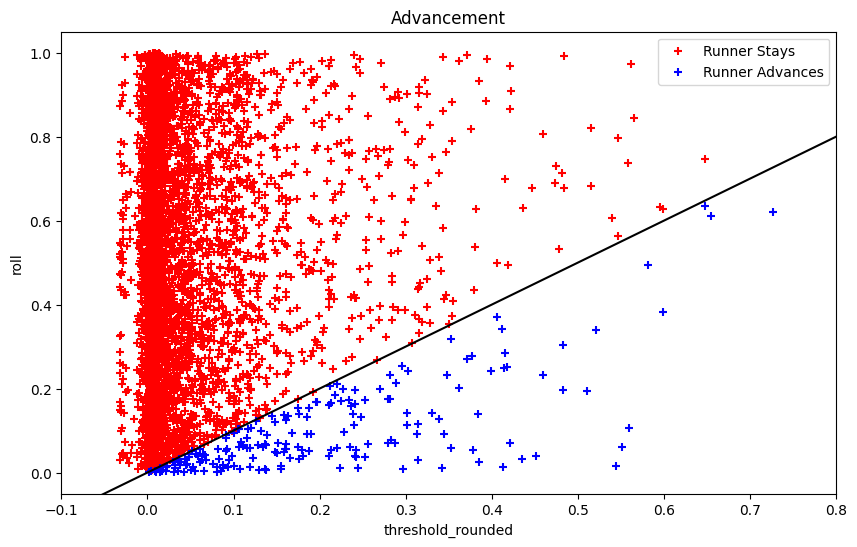

In [1381]:
# Make scatter plot

# Manual threshold
# dfc0["threshold_rounded"] = 0.01 - 0.08*dfc0["relevant_runner_indulgence_vibes"] + 0.32*dfc0["relevant_runner_indulgence_vibes_sq"] \
#                                 - 0.44*dfc0["relevant_runner_indulgence_vibes_3"] + 0.33*dfc0["relevant_runner_indulgence_vibes_4"] \
#                                 - 0.10*dfc0["ballpark_elongation"] - 0.10*dfc0["ballpark_inconvenience"]
dfc0["threshold_rounded"] = 0.01 - 0.10*dfc0["relevant_runner_indulgence_vibes"] + 0.40*dfc0["relevant_runner_indulgence_vibes_sq"] \
                                - 0.55*dfc0["relevant_runner_indulgence_vibes_3"] + 0.375*dfc0["relevant_runner_indulgence_vibes_4"] \
                                - 0.10*dfc0["ballpark_elongation"] - 0.10*dfc0["ballpark_inconvenience"]

# SVC threshold
dfc0["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        dfc0["threshold"] += pair[0] * dfc0[pair[1]]
# dfc0["threshold_rounded"] = dfc0["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
# x_val = "relevant_runner_indulgence_vibes"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc0[~dfc0["passed"]][x_val],
    dfc0[~dfc0["passed"]]["roll"],
    color="red",
    label="Runner Stays",
    marker="+",
)
ax.scatter(
    dfc0[dfc0["passed"]][x_val],
    dfc0[dfc0["passed"]]["roll"],
    color="blue",
    label="Runner Advances",
    marker="+",
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Advancement")
ax.set_xlim(-0.1, 0.8)
ax.set_ylim(-0.05, 1.05)
ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


3 outliers


/tmp/ipykernel_533/3773137864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc0["offset"] = dfc0["roll"] - dfc0["threshold_rounded"]


,passed,offset,roll,threshold_rounded,event_type,inning,relevant_runner_name,relevant_runner_mods,batting_team_mods,pitching_team_mods,weather,season,day,game_id,play_count
2521,False,-0.000183,0.192719,0.192901,advance_0,5,Don Mitchell,REVERBERATING,LOVE;EXTRA_STRIKE;BASE_DEALING,EXTRA_STRIKE;TRAVELING,Weather.FLOODING,12,28,1ca52a1e-05c0-4794-b171-8eec7eb978e7,247
8392,False,-0.000181,0.307499,0.307680,advance_0,2,Dickerson Morse,,,AFFINITY_FOR_CROWS,Weather.COFFEE_3S,14,68,32ddf5bb-98e4-48c8-b44d-37cdfafaf769,74
7366,True,0.000405,0.052085,0.051680,advance_0,12,Hahn Fox,,BASE_INSTINCTS,FIREPROOF;AMBUSH;SEALANT,Weather.REVERB,14,26,f7d56bee-6e3a-45d6-964e-03a00ddf748b,397


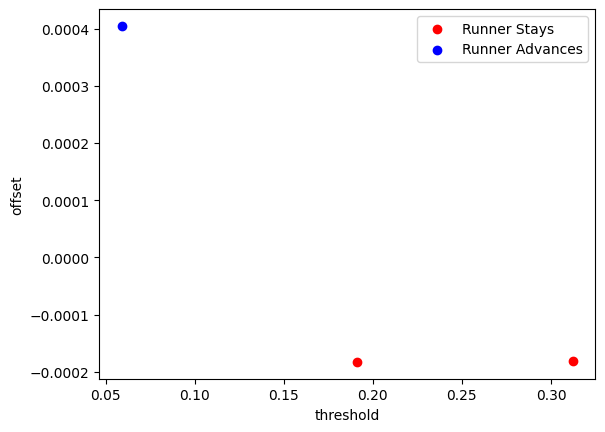

In [1382]:
# Plot outliers
dfc0["offset"] = dfc0["roll"] - dfc0["threshold_rounded"]
outliers = dfc0[(dfc0["passed"] & (dfc0["offset"] >= 0)) | (~dfc0["passed"] & (dfc0["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold_rounded",
        "event_type",
        "inning",
        "relevant_runner_name",
        # "fielder_name",
        "relevant_runner_mods",
        # "fielder_mods",
        "batting_team_mods",
        # "baserunners",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Advance Second Base to Third Base

### [1] -> [1] (fail) or [2] (pass)
### [1, 0] -> [1, 0] (fail) or [2, 0] (pass)
### [2, 1] -> [1] (fail) or [2] (pass)
### [2, 1, 0] -> [1, 0] (fail) or [2, 0] (pass)

In [1383]:
dfc1 = df[df['event_type']=='advance_1'].copy()

# dfc['relevant_runner_indulgence_vibes_log'] = dfc1['relevant_runner_indulgence_vibes'].apply(math.log)
dfc1['relevant_relevant_runner_indulgence_vibes_squh'] = dfc1['relevant_runner_indulgence_vibes']**2/(1 + 0.2*dfc1['relevant_runner_vibes'])
dfc1['relevant_relevant_runner_indulgence_vibes_sq'] = dfc1['relevant_runner_indulgence_vibes']**2
dfc1['relevant_runner_indulgence_vibes_pow'] = dfc1['relevant_runner_indulgence_vibes']**3.5
y = dfc1["passed"]
X = dfc1[
    [
        # "roll_log",
        "roll",
        # 'relevant_runner_indulgence_vibes_log',
        'relevant_runner_indulgence_vibes',
        'relevant_relevant_runner_indulgence_vibes_squh',
        'relevant_relevant_runner_indulgence_vibes_sq',
        'ballpark_inconvenience',
        'ballpark_elongation',
    ]
].copy()

# Test out a specific coefficient
X["roll"] = X["roll"]+0.1*X["ballpark_elongation"]
X.drop("ballpark_elongation", axis="columns", inplace=True)
X["roll"] = X["roll"]+0.1*X["ballpark_inconvenience"]
X.drop("ballpark_inconvenience", axis="columns", inplace=True)
X

,roll,relevant_runner_indulgence_vibes,relevant_relevant_runner_indulgence_vibes_squh,relevant_relevant_runner_indulgence_vibes_sq
1,0.476022,0.409026,0.184642,0.167302
2,0.664488,0.247573,0.058595,0.061292
3,0.131786,0.247573,0.058595,0.061292
11,0.188731,0.536595,0.308917,0.287934
15,0.767382,0.866326,0.765642,0.750520
...,...,...,...,...
9191,0.095650,0.777729,0.526497,0.604862
9192,0.379019,0.370648,0.150098,0.137380
9198,0.176204,0.673390,0.522265,0.453454
9203,0.409545,1.004184,0.863633,1.008385


In [1384]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[1781    4]
 [   2  549]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1785
        True       0.99      1.00      0.99       551

    accuracy                           1.00      2336
   macro avg       1.00      1.00      1.00      2336
weighted avg       1.00      1.00      1.00      2336

0.997431506849315


In [1385]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.04876137]


[(1.0, 'roll'),
 (-0.3110136371353465, 'relevant_relevant_runner_indulgence_vibes_sq'),
 (-0.04994139227595988, 'relevant_runner_indulgence_vibes'),
 (0.0006346783999419997, 'relevant_relevant_runner_indulgence_vibes_squh')]

[0.04876137]
(0.04994139227595988, 'relevant_runner_indulgence_vibes')
(-0.0006346783999419997, 'relevant_relevant_runner_indulgence_vibes_squh')
(0.3110136371353465, 'relevant_relevant_runner_indulgence_vibes_sq')


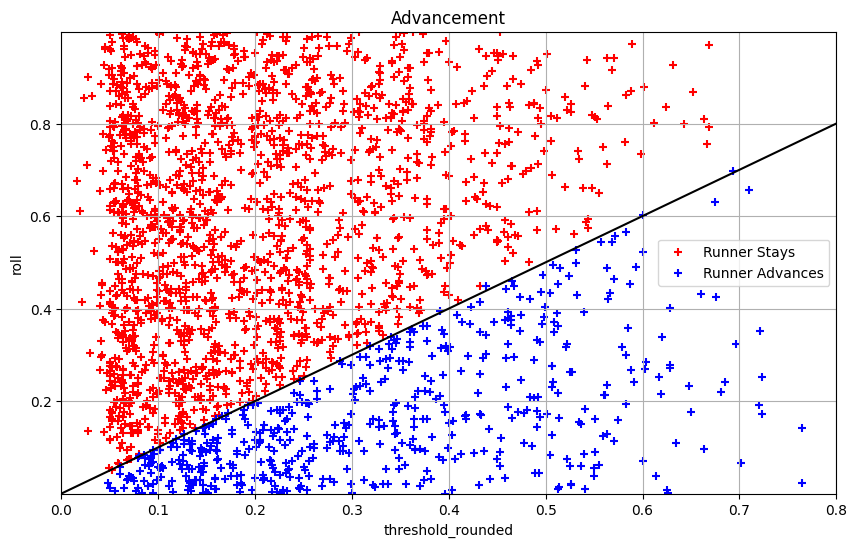

In [1386]:
# Make scatter plot

# Manual threshold
# dfc1["threshold_rounded"] = 0.045 + 0.065*dfc1["relevant_runner_indulgence_vibes"] + 0.30*dfc1["relevant_relevant_runner_indulgence_vibes_sq"] \
#                                  - 0.10*dfc1["ballpark_elongation"] - 0.10*dfc1["ballpark_inconvenience"]
dfc1["threshold_rounded"] = 0.05 - 0.10*dfc1["ballpark_elongation"] \
                                 - 0.10*dfc1["ballpark_inconvenience"] \
                                 + 0.0425*dfc1["relevant_runner_indulgence_vibes"] \
                                 + 0.31*dfc1["relevant_relevant_runner_indulgence_vibes_sq"]

# print(dfc1[dfc1["threshold_rounded"]>1]["runner_on_second_name"])
# dfc1["threshold_rounded"] = 0.50 + 0.35 * dfc1["relevant_runner_indulgence_vibes"] - 0.10 * dfc1['ballpark_elongation']
# print(dfc1[dfc1['passed'] & (dfc1['relevant_runner_indulgence_vibes']<0.2)][['roll','runner_on_second_mods','relevant_runner_indulgence_vibes','season','day']])

# SVC threshold
dfc1["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc1["threshold"] += pair[0] * dfc1[pair[1]]
# dfc1["threshold_rounded"] = dfc1["threshold_rounded"].clip(lower=0.001)

# x_val = "relevant_runner_indulgence_vibes"
x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc1[~dfc1["passed"]][x_val],
    dfc1[~dfc1["passed"]]["roll"],
    color="red",
    label="Runner Stays",
    marker="+",
)
ax.scatter(
    dfc1[dfc1["passed"]][x_val],
    dfc1[dfc1["passed"]]["roll"],
    color="blue",
    label="Runner Advances",
    marker="+",
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Advancement")
ax.grid()
# ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")
# ax.set_xlim(dfc1["threshold_rounded"].min(),dfc1["threshold_rounded"].max())
ax.set_xlim(0,0.8)
ax.set_ylim(dfc1["roll"].min(),dfc1["roll"].max())

ax.legend()


11 outliers


,passed,offset,roll,threshold_rounded,event_type,inning,relevant_runner_name,relevant_runner_indulgence_vibes,relevant_runner_mods,batting_team_mods,baserunners,pitching_team_mods,weather,season,day,game_id,play_count
502,False,-0.002250,0.050022,0.052272,advance_1,2,Freemium Seraph,0.041124,,,[1],FIREPROOF;SEALANT,Weather.BLACK_HOLE,11,50,f39c9443-4282-4833-9c41-6581502ffacc,82
7222,True,0.000028,0.118803,0.118775,advance_1,7,Lachlan Shelton,0.454856,,HIGH_PRESSURE,[1],SINKING_SHIP,Weather.FEEDBACK,14,20,5fef58d9-57e8-4530-a4af-1b8a9ae50042,232
1916,True,0.000467,0.166835,0.166368,advance_1,9,Ronan Combs,0.547959,ALTERNATE,,[1],LATE_TO_PARTY,Weather.FEEDBACK,12,5,ed480597-01bc-419a-8d63-036f00ae792d,310
377,True,0.000873,0.319699,0.318826,advance_1,6,Nandy Fantastic,0.865196,FIRST_BORN;TIRED,BIRD_SEED,[1],LOVE,Weather.COFFEE,11,44,311a6f59-f83b-4c3c-a9bc-08d95c54817b,251
1875,True,0.002140,0.161397,0.159257,advance_1,5,Matteo Triumphant,0.529065,,FIREPROOF;AMBUSH;SEALANT,"[2, 1]",EXTRA_STRIKE,Weather.PEANUTS,12,4,d09c9c42-9749-4ae3-b4dd-2d231cb734c6,228
95,True,0.002325,0.129435,0.127110,advance_1,2,Lang Richardson,0.434880,,AFFINITY_FOR_CROWS,[1],,Weather.BLACK_HOLE,11,33,56ee3bbe-aef9-4b46-a494-ba5d6d11f080,126
6079,True,0.002490,0.174820,0.172330,advance_1,3,Swamuel Mora,0.535345,,,"[1, 0]",,Weather.FEEDBACK,13,65,daea438a-5ec2-40b6-846f-711b4467a482,114
785,True,0.002529,0.602585,0.600056,advance_1,3,Ortiz Lopez,1.265270,FIRE_EATER,LOVE,[1],AFFINITY_FOR_CROWS,Weather.SUN_2,11,61,30e29942-85ab-4894-8f8e-09d9e0bfe15d,122
4931,True,0.004164,0.697295,0.693131,advance_1,0,Sigmund Castillo,1.383705,,BASE_INSTINCTS,"[2, 1]",BOTTOM_DWELLER,Weather.REVERB,13,16,4e50ff61-aef4-4738-9c61-b4199740437d,56
9203,True,0.004268,0.394852,0.390584,advance_1,0,Fish Summer,1.004184,FIRE_EATER,HIGH_PRESSURE,[1],CARCINIZATION;UNHOLEY,Weather.SUN_2,14,107,b6bc2efd-66b1-4470-8fac-9abf9ca7ec14,34


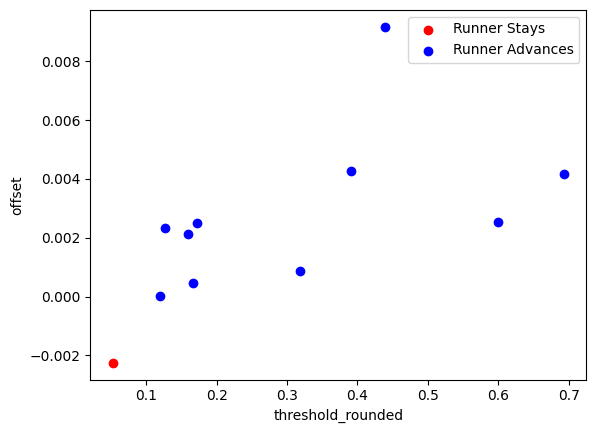

In [1387]:
# Outliers
dfc1["offset"] = dfc1["roll"] - dfc1["threshold_rounded"]
outliers = dfc1[(dfc1["passed"] & (dfc1["offset"] >= 0)) | (~dfc1["passed"] & (dfc1["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold_rounded",
        "event_type",
        "inning",
        "relevant_runner_name",
        "relevant_runner_indulgence_vibes",
        # "fielder_name",
        "relevant_runner_mods",
        # "fielder_mods",
        "batting_team_mods",
        "baserunners",
        "pitching_team_mods",
        "weather",
        "season",
        "day",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)

## Advance Third Base to Home (no hand-holding)

### [2] -> [2] (fail) or [] (pass)
### [2, 0] -> [2, 0] (fail) or [0] or [1] (pass)
### [2, 1] -> [2, 1] (fail) or [1] or [2] (pass)
### [2, 1, 0] -> [2, 1, 0] (fail) or [1, 0] or [2, 0] (pass)

,roll,relevant_runner_indulgence_vibes,ballpark_inconvenience,ballpark_elongation
0,0.232033,0.945747,0.000000,0.000000
5,0.596690,0.546263,0.000000,0.000000
10,0.959997,0.515180,0.000000,0.000000
14,0.222176,0.161536,0.000000,0.000000
20,0.894571,0.704957,0.000000,0.000000
...,...,...,...,...
9197,0.549785,0.680850,-0.048273,0.090171
9200,0.805531,0.646858,0.005260,0.075745
9201,0.438720,0.445105,0.005260,0.075745
9202,0.550469,1.297182,-0.004821,0.096597


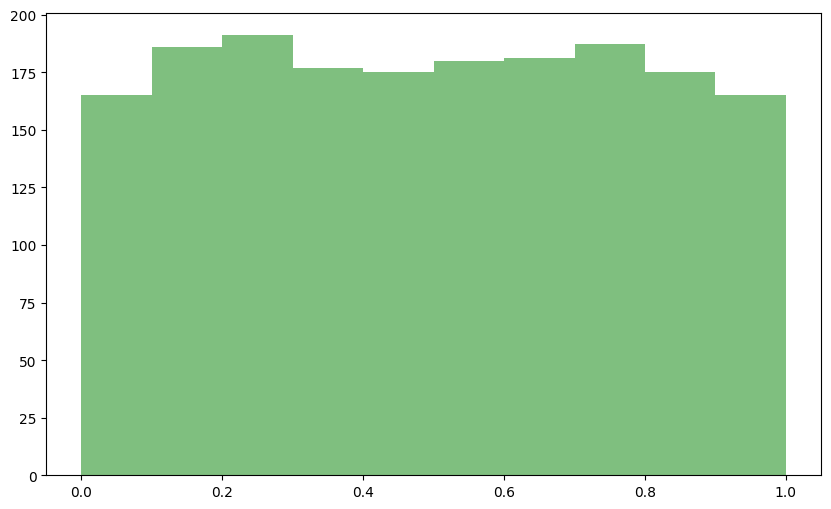

In [1388]:
dfc = df[df['event_type']=='advance_2'].copy()

# Plot the roll
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.hist(
    dfc['roll'],
    bins=10,
    range=[0.,1.],
    color="green",
    alpha = 0.5
)
# dfc["passed"] = ~dfc['baserunners_next'].str.contains("[2]")
# print(dfc[dfc["baserunners_next"] == "[0]"][["baserunners_next","passed"]])
# print(dfc[dfc["baserunners_next"] == "[1]"][["baserunners_next","passed"]])
# print(dfc["passed"])
# dfc['relevant_runner_indulgence_vibes'] = dfc['relevant_runner_indulgence_vibes_nomods']
dfc['relevant_runner_indulgence_vibes_2'] = dfc['relevant_runner_indulgence_vibes']**2
y = dfc["passed"]
X = dfc[
    [
        "roll",
        # "roll_avg",
        # "batter_patheticism_with_vibe",
        # "batter_inv_patheticism_with_vibe",
        # "batter_inv_patheticism",
        # "batter_tragicness_with_vibe",
        # "batter_inv_tragicness",
        # "batter_inv_patheticism",
        # "pitcher_shakespearianism_with_vibe",
        # 'fielder_anticapitalism_with_vibe',
        # 'fielder_chasiness_with_vibe',
        # 'fielder_omniscience_with_vibe',
        # 'fielder_tenaciousness_with_vibe',
        # 'fielder_watchfulness_with_vibe',
        # 'pitcher_anticapitalism_with_vibe',
        # 'pitcher_chasiness_with_vibe',
        # 'pitcher_omniscience_with_vibe',
        # 'pitcher_tenaciousness_with_vibe',
        # 'pitcher_watchfulness_with_vibe',
        'relevant_runner_indulgence_vibes',
        # 'relevant_runner_indulgence_vibes_2',
        # 'ballpark_grandiosity',
        # 'ballpark_fortification',
        # 'ballpark_obtuseness',
        # 'ballpark_ominousness',
        'ballpark_inconvenience',
        # 'ballpark_viscosity',
        # 'ballpark_forwardness',
        # 'ballpark_mysticism',
        'ballpark_elongation',
        # 'ballpark_filthiness',
    ]
]

# Test out a specific coefficient
# X["roll1"] = X["roll1"]+0.1*X["ballpark_elongation"]
# X.drop("ballpark_elongation", axis="columns", inplace=True)
# X["roll1"] = X["roll1"]+0.1*X["ballpark_inconvenience"]
# X.drop("ballpark_inconvenience", axis="columns", inplace=True)
X

In [1389]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler()
X2 = sc.fit_transform(X)    

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(
    X2, y
)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[ 553    1]
 [   0 1228]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       554
        True       1.00      1.00      1.00      1228

    accuracy                           1.00      1782
   macro avg       1.00      1.00      1.00      1782
weighted avg       1.00      1.00      1.00      1782

0.999438832772166


In [1390]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.45065521]


[(1.0, 'roll'),
 (-0.34759373267974836, 'relevant_runner_indulgence_vibes'),
 (0.10898438013013186, 'ballpark_elongation'),
 (0.10878087049165164, 'ballpark_inconvenience')]

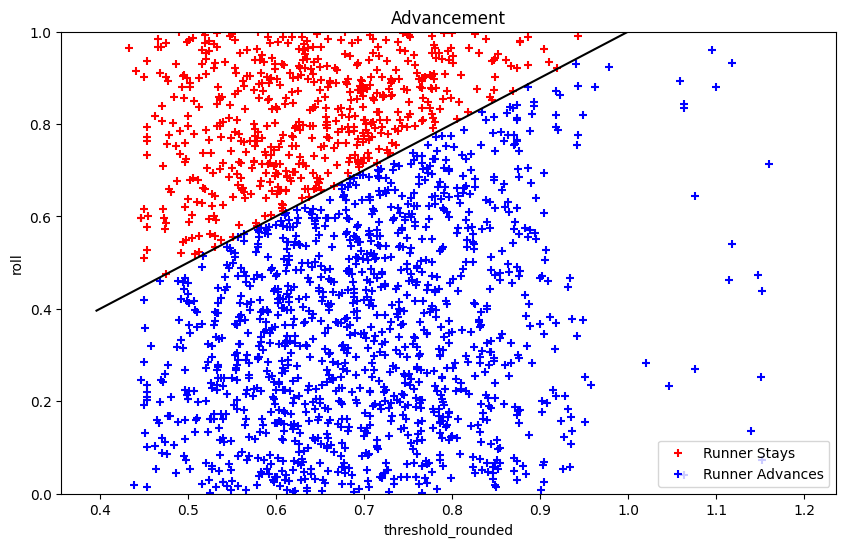

In [1391]:
# Make scatter plot

# Manual threshold
dfc["threshold_rounded"] = 0.45 + 0.35 * dfc["relevant_runner_indulgence_vibes"] - 0.10 * dfc["ballpark_elongation"] - 0.10 * dfc["ballpark_inconvenience"]
for thing in range(0,300,10):
    dfc.loc[dfc["threshold_rounded"].idxmax()]['threshold_rounded']

# SVC threshold
dfc["threshold"] = -intercept_scaled[0]
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        dfc["threshold"] += pair[0] * dfc[pair[1]]
# dfc["threshold_rounded"] = dfc["threshold_rounded"].clip(lower=0.001)

x_val = "threshold_rounded"
fig, ax = plt.subplots(1, figsize=(10, 6), facecolor='white')
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Runner Stays",
    marker="+",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    
    color="blue",
    label="Runner Advances",
    marker="+",
)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title("Advancement")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 1)

ax.plot(ax.get_xlim(), ax.get_xlim(), "k")

ax.legend()


0 outliers


,offset,passed,roll,threshold_rounded,event_type,inning,relevant_runner_name,relevant_runner_mods,batting_team_mods,pitching_team_mods,season,day,weather,game_id,play_count


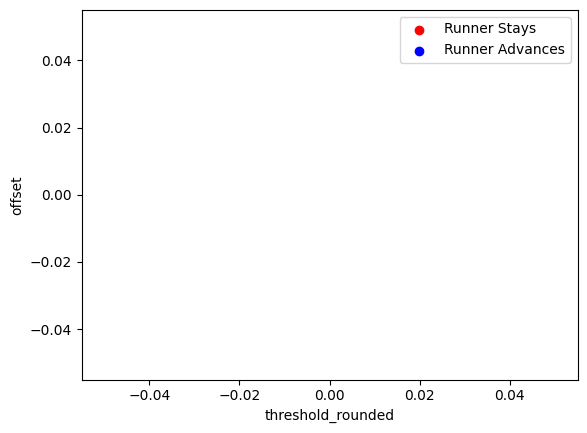

In [1392]:
# Outliers
dfc["offset"] = dfc["roll"] - dfc["threshold_rounded"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
print(f"{len(outliers)} outliers")

fig, ax = plt.subplots(1, facecolor='white')
x_val = "threshold_rounded"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Runner Stays",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Runner Advances",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

outliers[
    [
        "offset",
        "passed",
        "roll",
        "threshold_rounded",
        "event_type",
        "inning",
        "relevant_runner_name",
        "relevant_runner_mods",
        "batting_team_mods",
        # "fielder_name",
        # "fielder_mods",
        # "pitcher_name",
        # "pitcher_mods",
        "pitching_team_mods",
        "season",
        "day",
        "weather",
        "game_id",
        "play_count",
    ]
].sort_values("offset", ascending=True)